## Planet: Understanding The Amazon from Space

## [Overview](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/overview)


Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

[Dataset Description](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)

* train.csv - a list of training file names and their labels, the labels are space-delimited.

* sample_submission.csv - correct format of submission, contains all the files in the test set.

* [train/test]-tif-v2.tar.7z - tif files for the training/test set.

* [train/test]-jpg[-additional].tar.7z - jpg files for the trainin/test set.

* Kaggle-planet-[train/test]-tif.torrent - a BitTorrent file for downloading [train/test]-tif-v2.tar.7z.

### Importing Requried Libaries

In [ ]:
import subprocess
import os
import sys
import pandas as pd
import numpy as np
import pathlib
import scipy
import gc
from tqdm import tqdm

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

In [ ]:
# Install Kaggle API
!pip install --quiet kaggle

In [ ]:
# Choosing kaggle.json created for new API token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joyjoseph","key":"c88f2356342ee78cb2368e5217f8c966"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Check the file in its new directory
!ls /root/.kaggle/

# Check the file permission
!ls -l ~/.kaggle/kaggle.json

#Change the file permission
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json
-rw-r--r-- 1 root root 65 Mar 22 22:10 /root/.kaggle/kaggle.json


Downloading Dataset from Kaggle

In [ ]:
# Get the dataset 
!kaggle competitions download -c planet-understanding-the-amazon-from-space

planet-understanding-the-amazon-from-space.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:

! unzip planet-understanding-the-amazon-from-space.zip

Archive:  planet-understanding-the-amazon-from-space.zip
  inflating: Kaggle-planet-test-tif.torrent  
  inflating: Kaggle-planet-train-tif.torrent  
  inflating: sample_submission_v2.csv/sample_submission_v2.csv  
  inflating: test_v2_file_mapping.csv/test_v2_file_mapping.csv  
  inflating: train_v2.csv/train_v2.csv  


Reading the dataset

In [49]:
df = pd.read_csv('train_v2.csv/train_v2.csv')
df.columns = ["image_name", "tags"]
test_df = pd.read_csv('sample_submission_v2.csv/sample_submission_v2.csv')

In [50]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [51]:
test_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


The unique labels that will used for classification will be gotten

In [53]:
label_list = []
for tag_str in df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

            
# Display label list and number of labels in the dataset
print(f'There are {len(label_list)} possible unique classes.', '\n' 
      f'The Label list includes {label_list}')

There are 17 possible unique classes. 
The Label list includes ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [55]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df['tags'].values])))


# Create a label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'bare_ground': 0, 'agriculture': 1, 'partly_cloudy': 2, 'slash_burn': 3, 'blooming': 4, 'cultivation': 5, 'habitation': 6, 'artisinal_mine': 7, 'road': 8, 'cloudy': 9, 'water': 10, 'conventional_mine': 11, 'selective_logging': 12, 'primary': 13, 'clear': 14, 'haze': 15, 'blow_down': 16},
 length = 17


Applying One Hot Encoding on all the labels

In [56]:
# generating a target vector by applying one hot encoding to the unique labels --- e.g [0 0 0 1 0 0 0 0 0 0] for "bare_ground" tag.
df_data = df.copy()
for label in label_list:
    df_data[label] = df_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

# overview of the dataset
df_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


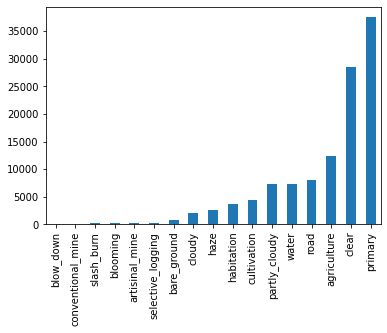

In [63]:
# Histogram of label instances
df_data[label_list].sum().sort_values().plot.bar()

In [57]:
# generating and printing the decreasing frequencies of
# instances for each category
category = {}

for column in df_data.columns[2:]:
     category[column] = df_data[column].value_counts()[1]

value = []
categor = []
for w in sorted(category, key=category.get, reverse=True):
  categor.append(w)
  value.append(category[w])
  print(category[w] , w )

37513 primary
28431 clear
12315 agriculture
8071 road
7411 water
7261 partly_cloudy
4477 cultivation
3660 habitation
2697 haze
2089 cloudy
862 bare_ground
340 selective_logging
339 artisinal_mine
332 blooming
209 slash_burn
100 conventional_mine
98 blow_down
